# Metin Oluşturu Model İnşa Etme

Halihazırda öğrenmiş olduğunuz tekniklerin çoğunu kullanarak, belirli bir ana kelimeyi takip eden bir sonraki kelimeyi tahmin ederek yeni metin oluşturmak artık mümkün. Bu yöntemi uygulamak için [Kaggle Şarkı Sözleri Veri Kümesini]((https://www.kaggle.com/mousehead/songlyrics)) kullanacağız.

## TensorFlow ve Gereli Fonksiyonların İçeri Aktarılması

In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Verilerin işlenmesi için diğer içeri aktarmalar
import string
import numpy as np
import pandas as pd

## Veri Setinin Alınması

Yukarıda belirttiğimiz gibi bu colab dosyasında model geliştirmek için şarkı sözleri veri setini kullanacağız.

In [2]:
!wget --no-check-certificate \
    https://drive.google.com/uc?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8 \
    -O /tmp/songdata.csv

--2021-07-28 20:25:55--  https://drive.google.com/uc?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8
Resolving drive.google.com (drive.google.com)... 172.217.9.206, 2607:f8b0:4004:806::200e
Connecting to drive.google.com (drive.google.com)|172.217.9.206|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/f58oiassacf7bh3bmkqa7c7dtaf96pt3/1627503900000/11118900490791463723/*/1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8 [following]
--2021-07-28 20:25:57--  https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/f58oiassacf7bh3bmkqa7c7dtaf96pt3/1627503900000/11118900490791463723/*/1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8
Resolving doc-04-ak-docs.googleusercontent.com (doc-04-ak-docs.googleusercontent.com)... 172.217.164.129, 2607:f8b0:4004:814::2001
Connecting to doc-04-ak-docs.googleusercontent.com (doc-04-ak-docs.googleusercontent.com)|172.217.164.129|

Önce veri setinden sadece 10 şarkıya bakalım ve işlerin nasıl performans gösterdiğini görelim.

## Ön İşleme Yapılması

Noktalama işaretlerinden kurtulmak ve her şeyi küçük harf yapmak için bazı temel önişlemeler yapalım. Daha sonra sözleri satırlara bölüp şarkı sözlerini belirteceğiz.


In [3]:
def tokenize_corpus(corpus, num_words=-1):
  # Tokenize ediciyi yerleştirin
  if num_words > -1:
    tokenizer = Tokenizer(num_words=num_words)
  else:
    tokenizer = Tokenizer()
  tokenizer.fit_on_texts(corpus)
  return tokenizer

def create_lyrics_corpus(dataset, field):
  # Diğer tüm noktalama işaretlerini kaldır
  dataset[field] = dataset[field].str.replace('[{}]'.format(string.punctuation), '')
  # küçük harf yap
  dataset[field] = dataset[field].str.lower()
  # Satıra göre bölmek için uzun bir dize yapın
  lyrics = dataset[field].str.cat()
  corpus = lyrics.split('\n')
  # Sondaki boşlukları kaldırın
  for l in range(len(corpus)):
    corpus[l] = corpus[l].rstrip()
  # Boş satırları kaldırın
  corpus = [l for l in corpus if l != '']

  return corpus

In [4]:
# Veri kümesini csv'den okuyun - şimdilik sadece ilk 10 şarkı
dataset = pd.read_csv('/tmp/songdata.csv', dtype=str)[:10]
# Şarkı sözlerini içeren 'metin' sütununu kullanarak derlemi oluşturun
corpus = create_lyrics_corpus(dataset, 'text')
# Tokenize edin
tokenizer = tokenize_corpus(corpus)

total_words = len(tokenizer.word_index) + 1

print(tokenizer.word_index)
print(total_words)

{'you': 1, 'i': 2, 'and': 3, 'a': 4, 'me': 5, 'the': 6, 'is': 7, 'my': 8, 'to': 9, 'ma': 10, 'it': 11, 'of': 12, 'im': 13, 'your': 14, 'love': 15, 'so': 16, 'as': 17, 'that': 18, 'in': 19, 'andante': 20, 'boomaboomerang': 21, 'make': 22, 'on': 23, 'oh': 24, 'for': 25, 'but': 26, 'new': 27, 'bang': 28, 'its': 29, 'be': 30, 'like': 31, 'know': 32, 'now': 33, 'how': 34, 'could': 35, 'youre': 36, 'sing': 37, 'never': 38, 'no': 39, 'chiquitita': 40, 'can': 41, 'we': 42, 'song': 43, 'had': 44, 'good': 45, 'youll': 46, 'she': 47, 'just': 48, 'girl': 49, 'again': 50, 'will': 51, 'take': 52, 'please': 53, 'let': 54, 'am': 55, 'eyes': 56, 'was': 57, 'always': 58, 'cassandra': 59, 'blue': 60, 'time': 61, 'dont': 62, 'were': 63, 'return': 64, 'once': 65, 'then': 66, 'sorry': 67, 'cryin': 68, 'over': 69, 'feel': 70, 'ever': 71, 'believe': 72, 'what': 73, 'do': 74, 'go': 75, 'all': 76, 'out': 77, 'think': 78, 'every': 79, 'leave': 80, 'look': 81, 'at': 82, 'way': 83, 'one': 84, 'music': 85, 'down': 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


## Dizilerin ve Etiketlerin Oluşturulması

Ön işlemeden sonra, sıralar ve etiketler oluşturmamız gerekiyor. Dizileri kendileri oluşturmak (`texts_to_sequences` ile öncekine benzer) ancak [N-Grams]((https://towardsdatascience.com/introduction-to-language-models-n-gram-e323081503d9)) kullanımını da içerir; etiketlerin oluşturulması artık bu dizileri kullanacak ve tüm potansiyel çıktı sözcükleri üzerinde `one-hot` kodlamayı kullanacak.


In [5]:
sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		sequences.append(n_gram_sequence)

# Eşit giriş uzunluğu için dolgu dizileri
max_sequence_len = max([len(seq) for seq in sequences])
sequences = np.array(pad_sequences(sequences, maxlen=max_sequence_len, padding='pre'))

# "Giriş" dizisi ve "çıkış" tahmin edilen kelime arasında dizileri bölme
input_sequences, labels = sequences[:,:-1], sequences[:,-1]
# Etiketlere one-hot kodlama
one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [6]:
# Bazı verilerimizin nasıl saklandığını kontrol edin
# Tokenizer, kelime başına yalnızca tek bir dizine sahiptir
print(tokenizer.word_index['know'])
print(tokenizer.word_index['feeling'])
# Giriş dizileri birden çok dizine sahip olacak
print(input_sequences[5])
print(input_sequences[6])
# Ve one-hot etiket, tokenize edilmiş kelimelerin tam olarak yayılması kadar uzun olacaktır
print(one_hot_labels[5])
print(one_hot_labels[6])

32
97
[  0   0   0   0   0   0   0   0   0   0   0   0   0  81  82 142 197  29
   4]
[  0   0   0   0   0   0   0   0   0   0   0   0  81  82 142 197  29   4
 287]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

## Metin Oluşturucu Modelin Eğitilmesi

Metin oluşturma modelimizi eğitmek için bir RNN oluşturmak, daha önce oluşturduğunuz duygu modellerine çok benzer olacaktır. Gerekli olan tek gerçek değişiklik, kayıp işlevi olarak İkili Çapraz Entropi (Binary Cross Entropy) yerine Kategorik'i (Categorical) kullandığınızdan emin olmaktır - daha önce duygu yalnızca 0 veya 1 olduğundan Binary'yi kullanabilirdik, ancak şimdi yüzlerce kategori var.

Metin oluşturmanın yakınsaması duygu analizine göre biraz daha uzun sürebileceğinden ve henüz o kadar çok veriyle çalışmıyoruz, çünkü bu noktadan sonra, öncekinden daha fazla dönem kullanmayı düşünmeliyiz. Veri kümesinin yalnızca bir kısmını kullandığımız için burada 200 çağa ayarlıyoruz ve eğitim bu kadar çok çağdan biraz daha geride kalacak.


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

model = Sequential()
model.add(Embedding(total_words, 64, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(20)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(input_sequences, one_hot_labels, epochs=200, verbose=1)

Epoch 1/200
62/62 [==============================] - 10s 8ms/step - loss: 5.9906 - accuracy: 0.0283
Epoch 2/200
62/62 [==============================] - 1s 8ms/step - loss: 5.4349 - accuracy: 0.0358
Epoch 3/200
62/62 [==============================] - 1s 8ms/step - loss: 5.3726 - accuracy: 0.0399
Epoch 4/200
62/62 [==============================] - 0s 8ms/step - loss: 5.3119 - accuracy: 0.0399
Epoch 5/200
62/62 [==============================] - 1s 9ms/step - loss: 5.2440 - accuracy: 0.0318
Epoch 6/200
62/62 [==============================] - 1s 9ms/step - loss: 5.1822 - accuracy: 0.0394
Epoch 7/200
62/62 [==============================] - 1s 9ms/step - loss: 5.1251 - accuracy: 0.0394
Epoch 8/200
62/62 [==============================] - 1s 9ms/step - loss: 5.0734 - accuracy: 0.0434
Epoch 9/200
62/62 [==============================] - 1s 9ms/step - loss: 5.0173 - accuracy: 0.0439
Epoch 10/200
62/62 [==============================] - 1s 9ms/step - loss: 4.9573 - accuracy: 0.0530
Epoch 11

## Eğitim Grafiğinin Oluşturulması 



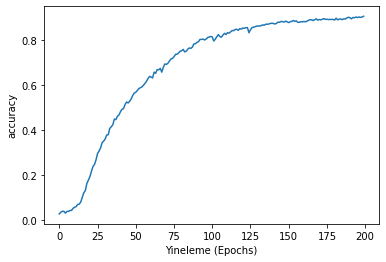

In [8]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Yineleme (Epochs)")
  plt.ylabel(string)
  plt.show()

plot_graphs(history, 'accuracy')

## Yeni Şarkı Sözleri Oluşturalım

Sonunda, eğitilmiş modelden yeni sözler üretmenin ve ne elde ettiğimizi görmenin zamanı geldi. Bunu yapmak için, modelin başlaması için bir miktar "tohum metni" (seed text) veya bir giriş sırası sağlayacağız. Ayrıca bir çıktı dizisinin ne kadar uzun olmasını istediğimize de karar vereceğiz - girdi artı önceki çıktı sürekli olarak yeni bir çıktı kelimesi için besleneceğinden (en azından maksimum dizi uzunluğumuza kadar) bu aslında sonsuz olabilir.

In [9]:
seed_text = "im feeling chills"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = np.argmax(model.predict(token_list), axis=-1)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

im feeling chills me to me every little touch touch lousy night night night night night night dont surrender surrender dont would surrender sky and with again and you gently more you leave me girl life us would feet feet night life sun have fellow be bone learn figure tiny leaving feeling cry words more of life of yourself once more more you leave more you leave talk feel talk night night night question of girl surrender surrender surrender surrender surrender surrender surrender surrender surrender surrender surrender would andante behind dont surrender surrender surrender surrender would front feet night night night night night
